# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d

In [2]:
def read_transformations(filename = "mr2020_project_data/poses.txt"):
    arr = np.loadtxt(filename)
    return arr
#     f = open(filename, 'r')
#     lines = f.readlines()
#     transformation_list = []
    
#     for i in range(len(lines)):
#         transformation_list_temp = lines[i].split()        
#         temp_rot = [] 
#         temp_rot.append( transformation_list_temp[0:4]  ) 
#         temp_rot.append( transformation_list_temp[4:8]   ) 
#         temp_rot.append( transformation_list_temp[8:12]   ) 
#         transformation_list.append(temp_rot)
#     return transformation_list

In [3]:
# def read_calibrations(filename = "mr2020_project_data/calib.txt"):
#     f = open(filename, 'r')
#     lines = f.readlines()
#     for line in lines:
#         p = line.split('\n')
#         print(p[0])
        
# read_calibrations()

In [4]:
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02], 
              [0.000000e+00, 7.070912e+02, 1.831104e+02], 
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
D = 0.53790448812

Provide explanation in this cell: 


In [8]:
import os
import matplotlib.pyplot as plt

In [10]:
LEFT_IMAGE_PATH = "mr2020_project_data/img2"
RIGHT_IMAGE_PATH = "mr2020_project_data/img3"
PC_PATH = 'point_clouds'

In [7]:
def write_ply(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3), colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [8]:
def make_disparitymap(img_left, img_right):
    imgL = cv2.imread(img_left)
    imgR = cv2.imread(img_right)

    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    # change its parameters
    stereo = cv2.StereoSGBM_create()
    disparity = stereo.compute(imgL,imgR).astype(np.float32)
    
    return disparity

In [35]:
transformations = read_transformations()

if not os.path.isdir(PC_PATH):
    os.mkdir(PC_PATH)

for file_name in sorted(os.listdir(LEFT_IMAGE_PATH)):
    img_left = os.path.join(LEFT_IMAGE_PATH, file_name)
    img_right = os.path.join(RIGHT_IMAGE_PATH, file_name)
    
    disparity = make_disparitymap(img_left, img_right)
    
    # disparity value was coming negative so
    # https://dsp.stackexchange.com/questions/25786/can-disparity-range-from-negative-to-positive-values-for-parallel-cameras
    disparity += abs(disparity.min())
    print(disparity.min())
    
    img = cv2.imread(img_left)
    
#     rev_proj_matrix = np.zeros((4,4)) 
    
#     cv2.stereoRectify(cameraMatrix1 = K, cameraMatrix2 = K, 
#                       distCoeffs1 = 0, distCoeffs2 = 0,
#                       imageSize = img.shape[:2],
#                       R = np.identity(3), T = np.array([D, 0., 0.]),
#                       Q = rev_proj_matrix)
    
#     h, w = img.shape[:2]
#     f = 7.070912e+02
#     rev_proj_matrix = np.float32([[1, 0, 0, -0.5*w],
#                         [0,-1, 0,  0.5*h], 
#                         [0, 0, 0, -f], 
#                         [0, 0, -1/D,  0]])
    
    points = cv2.reprojectImageTo3D(disparity, rev_proj_matrix)
    
    colors = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    mask = disparity > disparity.min()
    points = points[mask]
    colors = colors[mask]
    write_ply(points, colors,  os.path.join(PC_PATH, file_name[: -4] + ".ply"))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [11]:
# applying transformations per point cloud and joining all point clouds
transformations = read_transformations()

pcd = o3d.geometry.PointCloud()
cnt = 0

for trans_mat, file_name in zip(transformations,sorted(os.listdir(PC_PATH))):
    point_cloud = o3d.io.read_point_cloud(os.path.join(PC_PATH, file_name))
    trans_mat = trans_mat.reshape(3, 4)
    trans_mat = np.vstack((trans_mat, [0,0,0,1]))
    point_cloud = point_cloud.transform(trans_mat)
    pcd += point_cloud
    
# o3d.visualization.draw_geometries([pcd])

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [64]:
mu, sigma = 0, 0.1
R = np.random.normal(mu, sigma, (3, 3))
t = np.random.normal(mu, sigma, (3, 1))

P = K @ np.hstack((R,t))
print(P)

[[-1.02536468e+02  4.44939435e+01 -6.74214080e+01 -4.44819959e+01]
 [-9.44058060e+01  1.74985258e+01  5.49862939e+00 -1.09593943e+01]
 [-4.77497973e-02  3.89417194e-02 -8.11346621e-02 -5.77679094e-02]]


In [77]:
import random

In [78]:
points = np.asarray(pcd.points)
points_3d = []
points_2d = []

for i in random.sample(range(0, points.shape[0]), 100):
    # making homogenous coordinates
    pnt = P @ np.hstack((points[i], [1]))
    points_3d.append(np.hstack((points[i], [1])))
    points_2d.append(pnt)

points_3d = np.array(points_3d)
points_2d = np.array(points_2d)

In [96]:
def residual(points_2d, points_3d, P):
    res = []
    P = P.reshape((3,4))

    for i in range(points_2d.shape[0]):
        proj_point = P @ points_3d[i]
        norm = (points_2d[i] - proj_point)**2
        e = np.sum(norm)
        res.append(e)
        
    return np.array(res)
     
def jacobian(points_2d, points_3d, P):
    J = np.zeros((points_2d.shape[0], 12))
    
    for i in range(points_2d.shape[0]):
        x1, x2, x3 = points_2d[i]
        X1, X2, X3, X4 = points_3d[i]

        J[i][0] = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3 - P[3]*X4)* (-X1)
        J[i][1] = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3 - P[3]*X4)* (-X2)
        J[i][2] = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3 - P[3]*X4)* (-X3)
        J[i][3] = 2*(x1 - P[0]*X1 - P[1]*X2 - P[2]*X3 - P[3]*X4)* (-X4)

        J[i][4] = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3 - P[7]*X4)* (-X1)
        J[i][5] = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3 - P[7]*X4)* (-X2)
        J[i][6] = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3 - P[7]*X4)* (-X3)
        J[i][7] = 2*(x2 - P[4]*X1 - P[5]*X2 - P[6]*X3 - P[7]*X4)* (-X4)

        J[i][8] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X1)
        J[i][9] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X2)
        J[i][10] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X3)
        J[i][11] = 2*(x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4)* (-X4)
        
    return J

In [128]:
# initialize by adding random noise in original P
# proj = P.reshape((12,1)) + np.random.normal(mu, sigma, (12,1))
proj = np.zeros((12,1))

iterations = 0
e = residual(points_2d, points_3d, proj)
initial_err = np.sum(e)
# print("Initial Error:", initial_err)
err = [initial_err]

while True:
    iterations += 1
    J = jacobian(points_2d, points_3d, proj)
    e = residual(points_2d, points_3d, proj)
    
    # J^T @ J @ del_x = - J^T @ e
    del_proj = - np.linalg.pinv(J.T @ J) @ J.T @ e     
    proj += del_proj.reshape((12,1))
    err_val = np.sum(e)
    err.append(err_val)
#     print("Error values:", np.sum(e), "Iteration No:",i + 1)
#     print(proj.reshape(1,12))
#     print('\n')    
    if np.sum(e) < 1e-3:
        print(f"Converged in {iterations} iterations")
        break

Converged in 24 iterations


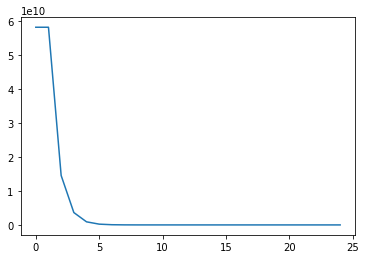

In [129]:
plt.plot(err)